# 06차시: 데이터 전처리 - 결측치 및 이상치 처리

## 학습 목표
- 실제 데이터에 존재하는 결측값(NaN) 처리 방법 학습
- 비정상적인 값(이상치)을 찾아내고 처리하는 기본 기법 학습

## 학습 내용
1. 결측치란?
2. 결측치 탐지 및 확인
3. 결측치 처리 방법
4. 이상치란?
5. 이상치 탐지 방법
6. 이상치 처리 방법
7. 종합 실습

## 구분
이론/실습

---
금융 데이터 분석에서 데이터 품질은 분석 결과의 신뢰성을 좌우합니다.
결측치와 이상치 처리는 모든 데이터 분석의 필수 전처리 과정입니다.


In [1]:
!pip install -q koreanize-matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [3]:
# 실습용 가상 주가 데이터 생성
print("[실습 데이터 준비: 가상 주가 데이터]")
print("=" * 60)

# 재현성을 위한 시드 설정
np.random.seed(42)

# 50일 영업일 기준 날짜 생성
dates = pd.date_range('2024-01-01', periods=50, freq='B')

# 기준 가격 (삼성전자 수준의 가격대)
base_price = 70000

# 가격 변동 시뮬레이션
price_changes = np.random.randn(50) * 800  # 일일 변동폭 약 ±800원
prices = base_price + np.cumsum(price_changes)

# OHLCV 데이터 생성
df = pd.DataFrame({
    '시가': (prices + np.random.randn(50) * 200).astype(int),
    '고가': (prices + abs(np.random.randn(50) * 500)).astype(int),
    '저가': (prices - abs(np.random.randn(50) * 500)).astype(int),
    '종가': prices.astype(int),
    '거래량': np.random.randint(10_000_000, 25_000_000, 50)
}, index=dates)
df.index.name = '날짜'

# 고가가 종가보다 크고, 저가가 종가보다 작도록 보정
df['고가'] = df[['고가', '종가', '시가']].max(axis=1)
df['저가'] = df[['저가', '종가', '시가']].min(axis=1)

print(f"종목: 가상 주식 (삼성전자 수준)")
print(f"데이터 크기: {df.shape[0]}행 x {df.shape[1]}열")
print(f"컬럼: {df.columns.tolist()}")
print(f"기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")

df.head()

[실습 데이터 준비: 가상 주가 데이터]
종목: 가상 주식 (삼성전자 수준)
데이터 크기: 50행 x 5열
컬럼: ['시가', '고가', '저가', '종가', '거래량']
기간: 2024-01-01 ~ 2024-03-08


,시가,고가,저가,종가,거래량
날짜,,,,,
2024-01-01,70462,71105,70272,70397,20192257
2024-01-02,70209,70497,70113,70286,19613273
2024-01-03,70669,70976,70464,70804,20683152
2024-01-04,72145,72424,71907,72023,14353127
2024-01-05,72042,72042,71689,71836,17315360


## 1. 결측치(Missing Value)란?

### 정의
- 데이터에서 값이 비어있거나 누락된 경우
- Pandas에서는 `NaN` (Not a Number) 또는 `None`으로 표현

### 결측치 발생 원인
| 원인 | 예시 |
|------|------|
| 데이터 수집 오류 | API 호출 실패, 네트워크 끊김 |
| 데이터 입력 누락 | 사람이 직접 입력하다 빠뜨림 |
| 시스템 장애 | 거래소 휴장, 시스템 점검 |
| 데이터 병합 | 서로 다른 기간의 데이터 합치기 |

### 금융 데이터에서의 결측치
- 휴장일 데이터 없음
- 신규 상장 이전 기간 데이터 없음
- 데이터 제공 서비스 오류


In [4]:
# 실습을 위해 인위적으로 결측치 생성
print("[결측치 포함 데이터 생성]")
print("=" * 60)

# 원본 데이터 복사
df_missing = df.copy()

# 결측치를 삽입할 위치 선택 (인덱스 5, 10, 15, 20, 25번째)
missing_positions = [5, 10, 15, 20, 25, 30, 35, 40]
missing_idx = df_missing.index[missing_positions]
missing_idx

[결측치 포함 데이터 생성]


DatetimeIndex(['2024-01-08', '2024-01-15', '2024-01-22', '2024-01-29',
               '2024-02-05', '2024-02-12', '2024-02-19', '2024-02-26'],
              dtype='datetime64[ns]', name='날짜', freq=None)

In [5]:
# 종가에 결측치 삽입 (4개)
df_missing.loc[missing_idx[:4], '종가'] = np.nan
# 거래량에 결측치 삽입 (4개)
df_missing.loc[missing_idx[4:], '거래량'] = np.nan

print("결측치가 포함된 데이터 생성 완료!")
print(f"데이터 크기: {len(df_missing)}행")
print(f"\n결측치 삽입 위치:")
print(f"  - 종가 결측: {[d.strftime('%m/%d') for d in missing_idx[:4]]}")
print(f"  - 거래량 결측: {[d.strftime('%m/%d') for d in missing_idx[4:]]}")

df_missing.loc[missing_idx]

결측치가 포함된 데이터 생성 완료!
데이터 크기: 50행

결측치 삽입 위치:
  - 종가 결측: ['01/08', '01/15', '01/22', '01/29']
  - 거래량 결측: ['02/05', '02/12', '02/19', '02/26']


,시가,고가,저가,종가,거래량
날짜,,,,,
2024-01-08,71834,71850,71291,NaN,24024490.0
2024-01-15,73117,74173,72726,NaN,13295990.0
2024-01-22,69945,69945,69467,NaN,23246988.0
2024-01-29,68504,68827,67986,NaN,16099628.0
2024-02-05,66982,67913,66404,66818.0,NaN
2024-02-12,64959,65778,64690,65003.0,NaN
2024-02-19,65208,66084,64952,65309.0,NaN
2024-02-26,63613,63708,63371,63594.0,NaN


## 2. 결측치 탐지 및 확인

### 주요 함수
| 함수 | 설명 |
|------|------|
| `df.isnull()` | 결측치 여부 (True/False) |
| `df.isna()` | isnull()과 동일 |
| `df.notnull()` | 결측치가 아닌지 여부 |
| `df.isnull().sum()` | 컬럼별 결측치 개수 |
| `df.info()` | 데이터 정보 (Non-Null Count 포함) |


In [6]:
# 결측치 탐지 방법 1: isnull()
print("[결측치 탐지: isnull()]")
print("=" * 60)

# 결측치 여부 확인 (처음 10행)
print("결측치 여부 (True = 결측치):")
print(df_missing.isnull().head(10))

print("\n" + "=" * 60)
# 컬럼별 결측치 개수
print("[컬럼별 결측치 개수]")
print(df_missing.isnull().sum())

[결측치 탐지: isnull()]
결측치 여부 (True = 결측치):
               시가     고가     저가     종가    거래량
날짜                                           
2024-01-01  False  False  False  False  False
2024-01-02  False  False  False  False  False
2024-01-03  False  False  False  False  False
2024-01-04  False  False  False  False  False
2024-01-05  False  False  False  False  False
2024-01-08  False  False  False   True  False
2024-01-09  False  False  False  False  False
2024-01-10  False  False  False  False  False
2024-01-11  False  False  False  False  False
2024-01-12  False  False  False  False  False

[컬럼별 결측치 개수]
시가     0
고가     0
저가     0
종가     4
거래량    4
dtype: int64


In [7]:
# 결측치 탐지 방법 2: info()
print("[데이터 정보: info()]")
print("=" * 60)
df_missing.info()

[데이터 정보: info()]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2024-01-01 to 2024-03-08
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      50 non-null     int64  
 1   고가      50 non-null     int64  
 2   저가      50 non-null     int64  
 3   종가      46 non-null     float64
 4   거래량     46 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 4.4 KB


## 3. 결측치 처리 방법

### 처리 방법 비교
| 방법 | 설명 | 장점 | 단점 |
|------|------|------|------|
| **삭제** | 결측치가 있는 행/열 제거 | 간단함 | 데이터 손실 |
| **대체 (평균)** | 평균값으로 채움 | 분포 유지 | 분산 감소 |
| **대체 (중앙값)** | 중앙값으로 채움 | 이상치에 강함 | 분산 감소 |
| **전방 채움** | 앞의 값으로 채움 | 시계열에 적합 | 트렌드 왜곡 가능 |
| **후방 채움** | 뒤의 값으로 채움 | 시계열에 적합 | 트렌드 왜곡 가능 |
| **보간법** | 선형/다항 보간 | 연속성 유지 | 복잡함 |

### 주요 함수
```python
df.dropna()              # 결측치가 있는 행 삭제
df.dropna(axis=1)        # 결측치가 있는 열 삭제
df.fillna(값)            # 특정 값으로 대체
df.fillna(method='ffill')     # 전방 채움 (Forward Fill)
df.fillna(method='bfill')    # 후방 채움 (Backward Fill)
df.interpolate()         # 선형 보간
```


In [8]:
# Step 1: 결측치 위치와 주변 값 확인
print("=" * 60)
print("[Step 1] 결측치 위치와 주변 값 확인")
print("=" * 60)

# 종가에서 결측치가 있는 날짜 찾기
missing_dates = df_missing[df_missing['종가'].isnull()].index
print(f"\n종가 결측치 개수: {len(missing_dates)}개")
print(f"결측치 날짜: {[d.strftime('%m/%d') for d in missing_dates]}")

# 결측치가 발생한 날짜 목록 중 첫 번째 결측 날짜 선택
first_missing = missing_dates[0]

# 인덱스 값(날짜)에 해당하는 정수 위치 반환
first_missing_pos = df_missing.index.get_loc(first_missing)

print(f"위치: {first_missing.strftime('%Y-%m-%d')} (인덱스 {first_missing_pos})")

[Step 1] 결측치 위치와 주변 값 확인

종가 결측치 개수: 4개
결측치 날짜: ['01/08', '01/15', '01/22', '01/29']
위치: 2024-01-08 (인덱스 5)


In [9]:
# Step-2 : 결측치 앞뒤 2일씩 출력
start_pos = max(0, first_missing_pos - 2)  # 인덱스가 음수가 되지 않도록 0과 비교하여 보정
end_pos = min(len(df_missing), first_missing_pos + 3)   # DataFrame 길이를 초과하지 않도록 보정

# 계산된 범위에 해당하는 데이터 슬라이싱
subset = df_missing.iloc[start_pos:end_pos][['종가']].copy()
# 결측치인 경우 '← 결측치' 표시
subset['상태'] = subset['종가'].apply(lambda x: '← 결측치' if pd.isna(x) else '')
subset

,종가,상태
날짜,,
2024-01-04,72023.0,
2024-01-05,71836.0,
2024-01-08,NaN,← 결측치
2024-01-09,72912.0,
2024-01-10,73526.0,


In [10]:
# Step 3: 방법 1 - 평균값으로 대체

# 평균값 계산
mean_val = df_missing['종가'].mean()

# 평균값으로 대체
df_mean = df_missing.copy()
df_mean['종가'] = df_mean['종가'].fillna(mean_val)

# 처리 전후 비교
comparison = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '평균대체': df_mean.loc[missing_dates, '종가'].astype(int)
})
comparison

,처리 전,평균대체
날짜,,
2024-01-08,NaN,67078
2024-01-15,NaN,67078
2024-01-22,NaN,67078
2024-01-29,NaN,67078


In [11]:
# Step 3: 방법 2, 3 - 전방/후방 채움

# 전방 채움
df_ffill = df_missing.copy()
df_ffill['종가'] = df_ffill['종가'].ffill()

# 처리 전후 비교
comparison_ffill = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '전방채움': df_ffill.loc[missing_dates, '종가'].astype(int)
})
comparison_ffill

,처리 전,전방채움
날짜,,
2024-01-08,NaN,71836
2024-01-15,NaN,73584
2024-01-22,NaN,70124
2024-01-29,NaN,67259


In [12]:
# 후방 채움
df_bfill = df_missing.copy()
df_bfill['종가'] = df_bfill['종가'].bfill()

comparison_bfill = pd.DataFrame({
    '처리 전': df_missing.loc[missing_dates, '종가'],
    '후방채움': df_bfill.loc[missing_dates, '종가'].astype(int)
})
comparison_bfill

,처리 전,후방채움
날짜,,
2024-01-08,NaN,72912
2024-01-15,NaN,72841
2024-01-22,NaN,68864
2024-01-29,NaN,68251


In [13]:
# 전체 비교표
print("\n" + "=" * 60)
print("[Step 5] 모든 방법 비교표")
print("=" * 60)

# 모든 방법 결과를 하나의 표로
all_comparison = pd.DataFrame({
    '원본(결측)': df_missing.loc[missing_dates, '종가'],
    '평균대체': df_mean.loc[missing_dates, '종가'].astype(int),
    '전방채움': df_ffill.loc[missing_dates, '종가'].astype(int),
    '후방채움': df_bfill.loc[missing_dates, '종가'].astype(int)
})
print(all_comparison)

print("\n" + "=" * 60)
print("[결론] 각 방법의 특징")
print("=" * 60)
print("  - 평균대체: 간단하지만 모든 결측치가 같은 값 → 추세 무시")
print("  - 전방채움: 전일 종가 사용 → 주가 데이터에 가장 적합")
print("  - 후방채움: 미래 데이터 사용 → 예측에는 부적합")


[Step 5] 모든 방법 비교표
            원본(결측)   평균대체   전방채움   후방채움
날짜                                     
2024-01-08     NaN  67078  71836  72912
2024-01-15     NaN  67078  73584  72841
2024-01-22     NaN  67078  70124  68864
2024-01-29     NaN  67078  67259  68251

[결론] 각 방법의 특징
  - 평균대체: 간단하지만 모든 결측치가 같은 값 → 추세 무시
  - 전방채움: 전일 종가 사용 → 주가 데이터에 가장 적합
  - 후방채움: 미래 데이터 사용 → 예측에는 부적합


## 4. 이상치(Outlier)란?

### 정의
- 데이터의 일반적인 분포에서 크게 벗어난 값
- 다른 데이터와 비교했을 때 비정상적으로 크거나 작은 값

### 이상치 발생 원인
| 원인 | 예시 |
|------|------|
| 데이터 입력 오류 | 오타, 단위 착오 |
| 측정 장비 오류 | 센서 오작동 |
| 실제 이상 현상 | 급등/급락, 시장 충격 |
| 데이터 처리 오류 | 병합 오류, 계산 실수 |

### 금융 데이터에서의 이상치
- 주가 급등/급락 (실제 이상 현상)
- 거래량 이상 급증
- 데이터 수집 오류로 인한 잘못된 가격

### 이상치 처리 시 주의점
- 금융 데이터에서 이상치가 **실제 시장 이벤트**인지 확인 필요
- 무조건 제거하면 중요한 정보 손실 가능


## 5. 이상치 탐지 방법

### IQR (Interquartile Range) 방법
```
Q1 (25% 백분위수): 데이터의 25% 지점
Q3 (75% 백분위수): 데이터의 75% 지점
IQR = Q3 - Q1

하한: Q1 - 1.5 * IQR
상한: Q3 + 1.5 * IQR

하한 미만 또는 상한 초과 → 이상치
```



In [14]:
# 이상치 탐지 실습을 위한 데이터 준비
print("[이상치 포함 데이터 생성]")
print("=" * 60)

# 원본 데이터 복사
df_outlier = df.copy()

# 정상 데이터 범위 확인
print(f"정상 종가 범위: {df_outlier['종가'].min():,}원 ~ {df_outlier['종가'].max():,}원")

# 인위적으로 이상치 삽입 (실습용) - 고정된 위치 사용
outlier_positions = [3, 25, 40]
outlier_idx = df_outlier.index[outlier_positions]

# 종가에 이상치 삽입 (비정상적으로 높거나 낮은 값)
df_outlier.loc[outlier_idx[0], '종가'] = 150000  # 비정상적으로 높음 (2배 이상)
df_outlier.loc[outlier_idx[1], '종가'] = 20000   # 비정상적으로 낮음 (1/3 이하)

print("\n이상치가 포함된 데이터 생성 완료!")
print(f"\n삽입된 이상치:")
print(f"  - {outlier_idx[0].strftime('%m/%d')}: 종가 150,000원 (비정상적으로 높음)")
print(f"  - {outlier_idx[1].strftime('%m/%d')}: 종가 20,000원 (비정상적으로 낮음)")

[이상치 포함 데이터 생성]
정상 종가 범위: 60,981원 ~ 73,584원

이상치가 포함된 데이터 생성 완료!

삽입된 이상치:
  - 01/04: 종가 150,000원 (비정상적으로 높음)
  - 02/05: 종가 20,000원 (비정상적으로 낮음)


In [15]:
# 이상치 탐지 방법: IQR 방법
print("[이상치 탐지: IQR 방법]")
print("=" * 60)

# 종가 컬럼에 대해 IQR 계산
Q1 = df_outlier['종가'].quantile(0.25)
Q3 = df_outlier['종가'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25%): {Q1:,.0f}원")
print(f"Q3 (75%): {Q3:,.0f}원")
print(f"IQR: {IQR:,.0f}원")
print(f"\n이상치 판단 기준:")
print(f"  하한: {lower_bound:,.0f}원")
print(f"  상한: {upper_bound:,.0f}원")

# 이상치 탐지
outliers_iqr = df_outlier[(df_outlier['종가'] < lower_bound) | (df_outlier['종가'] > upper_bound)]
print(f"\n탐지된 이상치 개수: {len(outliers_iqr)}개")
print("\n이상치 데이터:")
print(outliers_iqr[['시가', '고가', '저가', '종가', '거래량']])

[이상치 탐지: IQR 방법]
Q1 (25%): 63,775원
Q3 (75%): 70,369원
IQR: 6,594원

이상치 판단 기준:
  하한: 53,884원
  상한: 80,260원

탐지된 이상치 개수: 2개

이상치 데이터:
               시가     고가     저가      종가       거래량
날짜                                               
2024-01-04  72145  72424  71907  150000  14353127
2024-02-05  66982  67913  66404   20000  19674733


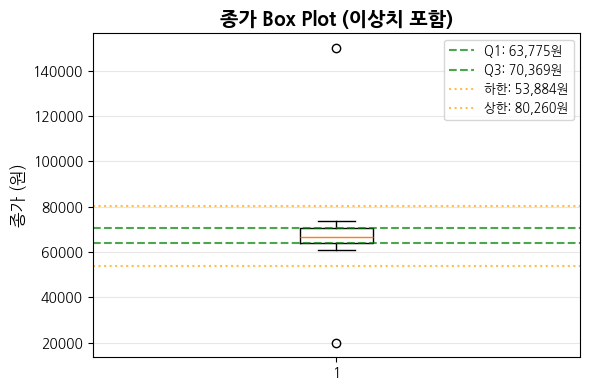

In [16]:
# 1. 기본 Box Plot (단일 Axes 사용)
fig, ax = plt.subplots(figsize=(6, 4))

# 종가 Box Plot
bp1 = ax.boxplot(df_outlier['종가'])

# 제목 및 축 라벨 설정
ax.set_title('종가 Box Plot (이상치 포함)', fontsize=14, fontweight='bold')
ax.set_ylabel('종가 (원)', fontsize=12)

# y축 기준 가로 격자선 표시
ax.grid(axis='y', alpha=0.3)

# IQR 기준선 추가
ax.axhline(y=Q1, color='green', linestyle='--', alpha=0.7, label=f'Q1: {Q1:,.0f}원')
ax.axhline(y=Q3, color='green', linestyle='--', alpha=0.7, label=f'Q3: {Q3:,.0f}원')
ax.axhline(y=lower_bound, color='orange', linestyle=':', alpha=0.7, label=f'하한: {lower_bound:,.0f}원')
ax.axhline(y=upper_bound, color='orange', linestyle=':', alpha=0.7, label=f'상한: {upper_bound:,.0f}원')

# 범례 표시
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

## 6. 이상치 처리 방법

### 처리 방법 비교
| 방법 | 설명 | 적용 상황 |
|------|------|----------|
| **삭제** | 이상치 행 제거 | 확실한 오류 데이터 |
| **대체 (평균/중앙값)** | 대표값으로 교체 | 일반적인 경우 |
| **로그 변환** | 분포 정규화 | 왜도가 큰 데이터 |
| **그대로 유지** | 이상치 보존 | 실제 이벤트인 경우 |

### 금융 데이터 처리 시 주의사항
- 급등/급락은 **실제 시장 이벤트**일 수 있음
- 무조건 제거하면 중요한 정보 손실
- 처리 전 **원인 분석** 필수


In [17]:
# 이상치 처리 방법 1: 삭제
print("[이상치 처리: 삭제]")
print("=" * 60)

# 원본 복사
df_remove = df_outlier.copy()

# 이상치 조건 (IQR 방법)
condition = (df_remove['종가'] >= lower_bound) & (df_remove['종가'] <= upper_bound)
df_removed = df_remove[condition]

print(f"원본 데이터: {len(df_outlier)}행")
print(f"이상치 제거 후: {len(df_removed)}행")
print(f"제거된 행 수: {len(df_outlier) - len(df_removed)}행")

[이상치 처리: 삭제]
원본 데이터: 50행
이상치 제거 후: 48행
제거된 행 수: 2행


In [19]:
# 이상치 처리 방법 2: 대체 (중앙값)
print("[이상치 처리: 중앙값으로 대체]")
print("=" * 60)

# 원본 복사
df_replace = df_outlier.copy()

# 종가 컬럼을 float로 변환
df_replace['종가'] = df_replace['종가'].astype(float)

# 중앙값 계산 (이상치 제외)
normal_data = df_replace[(df_replace['종가'] >= lower_bound) & (df_replace['종가'] <= upper_bound)]
median_price = normal_data['종가'].median()

print(f"정상 데이터 중앙값: {median_price:,.0f}원")

# 이상치를 중앙값으로 대체
df_replace.loc[(df_replace['종가'] < lower_bound) | (df_replace['종가'] > upper_bound), '종가'] = median_price

print(f"\n대체 후 이상치 개수: {len(df_replace[(df_replace['종가'] < lower_bound) | (df_replace['종가'] > upper_bound)])}개")

[이상치 처리: 중앙값으로 대체]
정상 데이터 중앙값: 66,606원

대체 후 이상치 개수: 0개


## 배운 내용 정리

### 1. 결측치 (Missing Value)
- **탐지**: `isnull()`, `isna()`, `info()`
- **삭제**: `dropna()`
- **대체**: `fillna(값)`, `fillna(method='ffill')`

### 2. 이상치 (Outlier)
- **IQR 방법**: Q1 - 1.5*IQR ~ Q3 + 1.5*IQR 범위 초과

### 3. 이상치 처리
- **삭제**: 확실한 오류 데이터
- **대체**: 평균, 중앙값으로 교체

### 4. 금융 데이터 처리 시 주의사항
- 급등/급락은 실제 시장 이벤트일 수 있음
- 무조건 제거하지 않고 원인 분석 필요
- 주가 데이터는 전방 채움(ffill)이 일반적

---
